In [2]:
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2021-12-02 13:37:40.302071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 13:37:40.302093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
skim = pq.read_table("Skim_neweta.parquet")

In [4]:
df = skim.to_pandas()

In [5]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [6]:
df["label"] = 0

In [7]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [8]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [9]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [10]:
input_vars=["Eta_ph1","Phi_ph1","E_mGG_ph1","pT_mGG_ph1","Eta_ph2","Phi_ph2","E_mGG_ph2","pT_mGG_ph2","Electron_E","Electron_pT","Electron_Eta","Electron_Phi","Muon_E","Muon_pT","Muon_Eta","Muon_Phi","nJets","E_jet1","pT_jet1","Eta_jet1","Phi_jet1","E_jet2","pT_jet2","Eta_jet2","Phi_jet2","InvM_jet","InvM_jet2", "met"]

In [11]:
print(df[input_vars])

       Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4    -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...        ...         ...       ...       ...   
3691  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
0      2.815203    0.482479   32.269810    30.670956  ...   75.722549   
1

In [12]:
df_clean = df[input_vars].copy()
df_clean["label"] = df.loc[:,"label"]
df_clean.to_csv("dataframe_HHWWgg.csv")


In [34]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.weight, 
                                                    test_size=0.33, random_state=42)

In [35]:
print(X_train)

        Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
34136  0.057177  0.345513   0.768055    0.766801 -0.826898  1.577488   
7721  -2.569575 -1.486616   3.536711    0.538442 -2.733758  2.299979   
92388  0.270710 -1.123389   0.576167    0.555681 -1.713670 -1.740383   
26658 -0.332751 -1.438163   3.501870    3.316559  0.360015 -1.666789   
60895  1.469115  2.982729   1.162908    0.508318  0.031838 -0.485319   
...         ...       ...        ...         ...       ...       ...   
49980  0.112235  1.455793   1.439577    1.430557 -0.652633  1.940947   
8560   0.585558  1.438181   0.973537    0.827561  0.022277 -2.018127   
62033  0.637464 -3.004317   1.043250    0.862080  0.982383  0.993843   
76968  0.388067  0.935610   0.769792    0.715256  0.220403 -1.414086   
52059  1.350768 -2.877273   2.051052    0.995794  2.114313 -0.926461   

       E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
34136   0.818760    0.601229    0.000000     0.000000  ...  2

In [36]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
6250   -1.072263  1.662017   0.727666    0.445844  0.396845 -0.778597   
4144    2.358899  1.358941   2.655672    0.497605  1.753551 -2.306685   
90774   0.151232  0.714887   1.115735    1.103096  0.415717 -1.148945   
43295   0.986995 -0.956442   1.110630    0.726886  0.441631  2.434214   
73023   0.726484  2.534710   1.577874    1.236868 -0.489011 -2.834955   
...          ...       ...        ...         ...       ...       ...   
24112   0.485446  2.117396   1.931196    1.724034  0.448685  2.706167   
153413  1.450403 -2.403589   0.760150    0.337896 -1.284254 -3.039068   
96072  -2.570435 -2.452506   2.789517    0.424326 -0.395019 -1.701105   
2933    2.663880  0.381031   6.625505    0.918835  2.351120 -1.977981   
2966   -0.457320 -0.687372   0.664367    0.600473 -0.334350  2.199187   

        E_mGG_ph2  pT_mGG_ph2   Electron_E  Electron_pT  ...     pT_jet1  \
6250     0.396775    0.367459    42.441544    2

In [32]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [46]:
X_val = X_train[-3000:]
y_val = y_train[-3000:]
w_val = w_train[-3000:]
X_train = X_train[:-3000]
y_train = y_train[:-3000]
w_train = w_train[:-3000]

In [47]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
34136   0.057177  0.345513   0.768055    0.766801 -0.826898  1.577488   
7721   -2.569575 -1.486616   3.536711    0.538442 -2.733758  2.299979   
92388   0.270710 -1.123389   0.576167    0.555681 -1.713670 -1.740383   
26658  -0.332751 -1.438163   3.501870    3.316559  0.360015 -1.666789   
60895   1.469115  2.982729   1.162908    0.508318  0.031838 -0.485319   
...          ...       ...        ...         ...       ...       ...   
139586  0.916275  2.373846   1.269876    0.875787  0.488028  0.727581   
3704   -0.379656 -0.748872   0.620624    0.578433  0.999270  1.009912   
20157   0.072576  0.196121   0.318718    0.317880 -2.232246 -1.344043   
137892  0.474690 -0.021929   0.728349    0.653347 -0.948858 -0.547173   
82856  -0.477069  2.396670   0.719896    0.645085  0.098753 -1.917348   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
34136    0.818760    0.601229    0.000000     0.

In [48]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val,w_val),
)

Epoch 1/10
1663/1663 [==============================] - 2s 1ms/step - loss: 1.7009e-04 - binary_accuracy: 0.8005 - val_loss: 454.1929 - val_binary_accuracy: 0.7987
Epoch 2/10
1663/1663 [==============================] - 2s 1ms/step - loss: 1.3812e-04 - binary_accuracy: 0.8005 - val_loss: 352.4904 - val_binary_accuracy: 0.7987
Epoch 3/10
1663/1663 [==============================] - 2s 1ms/step - loss: 6.4601e-04 - binary_accuracy: 0.8005 - val_loss: 397.8209 - val_binary_accuracy: 0.7987
Epoch 4/10
1663/1663 [==============================] - 2s 1ms/step - loss: 2.1852e-04 - binary_accuracy: 0.8005 - val_loss: 404.7775 - val_binary_accuracy: 0.7987
Epoch 5/10
1663/1663 [==============================] - 2s 1ms/step - loss: 9.4990e-04 - binary_accuracy: 0.8005 - val_loss: 417.6068 - val_binary_accuracy: 0.7987
Epoch 6/10
1663/1663 [==============================] - 2s 1ms/step - loss: 8.1902e-04 - binary_accuracy: 0.8005 - val_loss: 449.1705 - val_binary_accuracy: 0.7987
Epoch 7/10
1663/

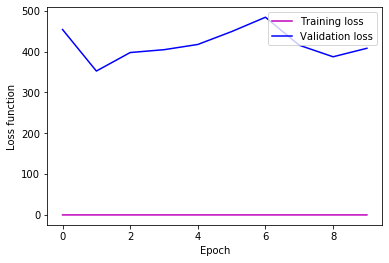

In [49]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
#plt.savefig('plots/2016_training_validation.pdf')
plt.show()

[[8.2171427e-18]
 [1.5157635e-17]
 [2.4367376e-36]
 ...
 [3.1085342e-06]
 [2.7743101e-09]
 [1.7416067e-18]]


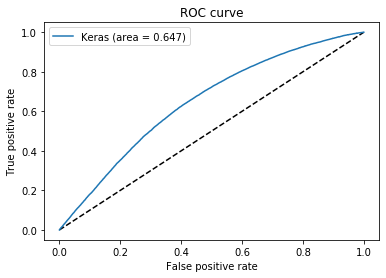

In [41]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
#y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

print(prediction)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("ROC_curve.pdf")
plt.show()

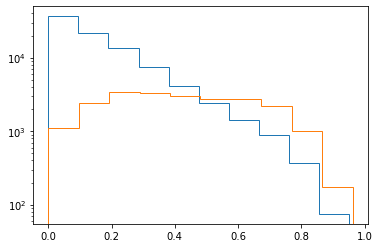

In [46]:
plt.hist(prediction[y_test==0],histtype=("step"));
plt.hist(prediction[y_test==1],histtype=("step"));
plt.yscale('log') 
plt.savefig("prediction.pdf", dpi = 300)

In [47]:
# evaluate the model
scores = model.evaluate(X_test, y_test, w_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3460/3460 - 2s - loss: 0.3782 - binary_accuracy: 0.8355 - 2s/epoch - 459us/step
binary_accuracy: 83.55%


In [48]:
# save model and architecture to single file
model.save("model_dnn_neweta")
print("Saved model to disk")

INFO:tensorflow:Assets written to: model_dnn_neweta/assets
Saved model to disk
